# Monet Style Transfer with GANs - Kaggle Mini-Project
### Author: Tomek Mierzwa

This project uses the Kaggle *Monet Paintings* dataset and a CycleGAN model to transform photos into Monet-style paintings.

**Dataset overview:**
- `monet_tfrec`: 300 Monet paintings (256x256, TFRecord)
- `photo_tfrec`: 7,028 photos (256x256, TFRecord)

**Evaluation metric:** MiFID (Memorization-informed Fréchet Inception Distance).

**Deliverables:**
1. Jupyter notebook (this file)
2. Public GitHub repo
3. Kaggle submission (`images.zip` with 7k–10k Monet-style images, 256x256)


In [15]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os, random, zipfile

print('TensorFlow:', tf.__version__)
print('GPUs:', tf.config.list_physical_devices('GPU'))

TensorFlow: 2.16.2
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Section 1: Dataset Loading (TFRecords only)

In [16]:
# Paths for TFRecord files
monet_tfrecords = tf.io.gfile.glob('./data/gan-getting-started/monet_tfrec/*.tfrec')
photo_tfrecords = tf.io.gfile.glob('./data/gan-getting-started/photo_tfrec/*.tfrec')
print('Monet TFRecords:', len(monet_tfrecords))
print('Photo TFRecords:', len(photo_tfrecords))

Monet TFRecords: 5
Photo TFRecords: 20


In [17]:
# TFRecord parsing utilities
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 127.5 - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        'image': tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    return decode_image(example['image'])

def load_dataset(filenames, batch_size=1):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(2048).batch(batch_size)
    return dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

monet_ds = load_dataset(monet_tfrecords)
photo_ds = load_dataset(photo_tfrecords)


2025-09-29 13:42:22.917967: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-09-29 13:42:23.343742: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


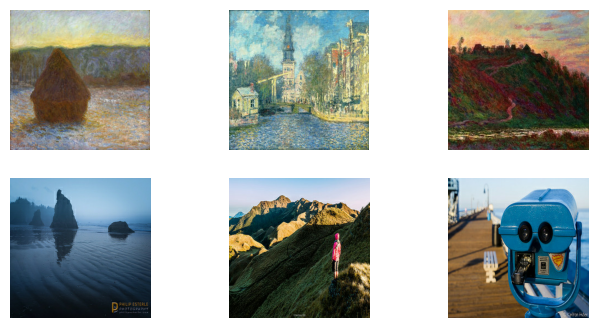

In [18]:
# Visualize few Monet vs Photo samples
plt.figure(figsize=(8,4))
for i, img in enumerate(monet_ds.take(3)):
    plt.subplot(2,3,i+1)
    plt.imshow((img[0].numpy()+1)/2)
    plt.axis('off')
    if i==0: plt.ylabel('Monet')
for i, img in enumerate(photo_ds.take(3)):
    plt.subplot(2,3,i+4)
    plt.imshow((img[0].numpy()+1)/2)
    plt.axis('off')
    if i==0: plt.ylabel('Photo')
plt.show()

## Section 2: CycleGAN Model

In [19]:
from tensorflow.keras import layers

def downsample(filters, size, apply_batchnorm=True):
    result = tf.keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=tf.random_normal_initializer(0., 0.02),
                             use_bias=False))
    if apply_batchnorm:
        result.add(layers.BatchNormalization())
    result.add(layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    result = tf.keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                      kernel_initializer=tf.random_normal_initializer(0., 0.02),
                                      use_bias=False))
    result.add(layers.BatchNormalization())
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

def Generator():
    inputs = layers.Input(shape=[256,256,3])
    down1 = downsample(64,4,apply_batchnorm=False)(inputs)
    down2 = downsample(128,4)(down1)
    up1 = upsample(64,4)(down2)
    last = layers.Conv2DTranspose(3,4,strides=2,padding='same',
                                  kernel_initializer=tf.random_normal_initializer(0.,0.02),
                                  activation='tanh')(up1)
    return tf.keras.Model(inputs=inputs, outputs=last)

def Discriminator():
    inp = layers.Input(shape=[256,256,3])
    x = layers.Conv2D(64,4,strides=2,padding='same')(inp)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(128,4,strides=2,padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(1,4,strides=1,padding='same')(x)
    return tf.keras.Model(inputs=inp, outputs=x)


In [20]:
# Instantiate models
gen_g = Generator()  # Photo->Monet
gen_f = Generator()  # Monet->Photo
disc_x = Discriminator()
disc_y = Discriminator()

print("Generator G (Photo -> Monet):")
gen_g.summary()
print("\nGenerator F (Monet -> Photo):")
gen_f.summary()
print("\nDiscriminator X:")
disc_x.summary()
print("\nDiscriminator Y:")
disc_y.summary()

Generator G (Photo -> Monet):


Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_12 (Sequential)      │ (None, 128, 128, 64)   │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_13 (Sequential)      │ (None, 64, 64, 128)    │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_14 (Sequential)      │ (None, 128, 128, 64)   │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 256, 256, 3)    │         3,075 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 269,059 (1.03 MB)

 Trainable params: 268,675 (1.02 MB)

 Non-trainable params: 384 (1.50 KB)


Generator F (Monet -> Photo):


Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_24 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_15 (Sequential)      │ (None, 128, 128, 64)   │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_16 (Sequential)      │ (None, 64, 64, 128)    │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_17 (Sequential)      │ (None, 128, 128, 64)   │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_11             │ (None, 256, 256, 3)    │         3,075 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 269,059 (1.03 MB)

 Trainable params: 268,675 (1.02 MB)

 Non-trainable params: 384 (1.50 KB)


Discriminator X:


Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_28 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_20 (LeakyReLU)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_21 (LeakyReLU)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 64, 64, 1)      │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136,897 (534.75 KB)

 Trainable params: 136,641 (533.75 KB)

 Non-trainable params: 256 (1.00 KB)


Discriminator Y:


Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_29 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_22 (LeakyReLU)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_23 (LeakyReLU)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 64, 64, 1)      │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136,897 (534.75 KB)

 Trainable params: 136,641 (533.75 KB)

 Non-trainable params: 256 (1.00 KB)

## Section 3: Training Loop

In [11]:
# Loss functions
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake):
    return loss_obj(tf.ones_like(fake), fake)

def discriminator_loss(real, fake):
    real_loss = loss_obj(tf.ones_like(real), real)
    fake_loss = loss_obj(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5

LAMBDA_CYCLE = 10
LAMBDA_IDENTITY = 5

def cycle_loss(real_image, cycled_image):
    return LAMBDA_CYCLE * tf.reduce_mean(tf.abs(real_image - cycled_image))

def identity_loss(real_image, same_image):
    return LAMBDA_IDENTITY * tf.reduce_mean(tf.abs(real_image - same_image))

# Optimizers
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Full training step
@tf.function
def train_step(real_x, real_y):
    # real_x = photos, real_y = monets
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates Photo -> Monet
        # Generator F translates Monet -> Photo
        fake_y = gen_g(real_x, training=True)
        fake_x = gen_f(real_y, training=True)

        cycled_x = gen_f(fake_y, training=True)
        cycled_y = gen_g(fake_x, training=True)

        same_x = gen_f(real_x, training=True)
        same_y = gen_g(real_y, training=True)

        disc_real_x = disc_x(real_x, training=True)
        disc_real_y = disc_y(real_y, training=True)

        disc_fake_x = disc_x(fake_x, training=True)
        disc_fake_y = disc_y(fake_y, training=True)

        # Generator adversarial loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        # Cycle loss
        total_cycle_loss = cycle_loss(real_x, cycled_x) + cycle_loss(real_y, cycled_y)

        # Identity loss
        id_loss_g = identity_loss(real_y, same_y)
        id_loss_f = identity_loss(real_x, same_x)

        # Total generator losses
        total_gen_g_loss = gen_g_loss + total_cycle_loss + id_loss_g
        total_gen_f_loss = gen_f_loss + total_cycle_loss + id_loss_f

        # Discriminator losses
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Calculate and apply gradients
    generator_g_gradients = tape.gradient(total_gen_g_loss, gen_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, gen_f.trainable_variables)
    discriminator_x_gradients = tape.gradient(disc_x_loss, disc_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, disc_y.trainable_variables)

    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, gen_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, gen_f.trainable_variables))
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, disc_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, disc_y.trainable_variables))

    return {
        "gen_g_loss": total_gen_g_loss,
        "gen_f_loss": total_gen_f_loss,
        "disc_x_loss": disc_x_loss,
        "disc_y_loss": disc_y_loss
    }

EPOCHS = 15

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    for step, (photo, monet) in enumerate(tf.data.Dataset.zip((photo_ds, monet_ds))):
        losses = train_step(photo, monet)
        if step % 100 == 0:
            print(f"  Step {step}: "
                  f"G_g={losses['gen_g_loss'].numpy():.3f}, "
                  f"G_f={losses['gen_f_loss'].numpy():.3f}, "
                  f"D_x={losses['disc_x_loss'].numpy():.3f}, "
                  f"D_y={losses['disc_y_loss'].numpy():.3f}")

Epoch 1/15
  Step 0: G_g=4.871, G_f=5.815, D_x=0.550, D_y=0.763
  Step 100: G_g=4.687, G_f=5.492, D_x=0.815, D_y=0.569
  Step 200: G_g=5.327, G_f=5.335, D_x=0.681, D_y=0.405


2025-09-29 13:57:54.164769: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2/15
  Step 0: G_g=4.307, G_f=3.674, D_x=0.499, D_y=0.515
  Step 100: G_g=4.562, G_f=5.154, D_x=0.515, D_y=0.744
  Step 200: G_g=4.099, G_f=4.425, D_x=0.681, D_y=0.723


2025-09-29 13:58:22.973353: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 3/15
  Step 0: G_g=5.653, G_f=6.317, D_x=0.660, D_y=0.509
  Step 100: G_g=4.921, G_f=4.804, D_x=0.636, D_y=0.714
  Step 200: G_g=7.424, G_f=6.086, D_x=0.444, D_y=0.478


2025-09-29 13:58:51.763334: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4/15
  Step 0: G_g=5.111, G_f=5.621, D_x=0.516, D_y=0.792
  Step 100: G_g=5.578, G_f=6.457, D_x=0.780, D_y=0.878
  Step 200: G_g=4.207, G_f=4.694, D_x=0.657, D_y=0.695


2025-09-29 13:59:20.492020: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 5/15
  Step 0: G_g=4.451, G_f=4.798, D_x=0.579, D_y=0.591
  Step 100: G_g=4.873, G_f=5.060, D_x=0.515, D_y=0.612
  Step 200: G_g=3.087, G_f=3.523, D_x=0.637, D_y=0.637


2025-09-29 13:59:49.053376: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 6/15
  Step 0: G_g=6.707, G_f=6.957, D_x=0.557, D_y=0.631
  Step 100: G_g=4.130, G_f=4.154, D_x=0.514, D_y=0.533
  Step 200: G_g=4.566, G_f=3.989, D_x=0.613, D_y=0.753


2025-09-29 14:00:17.254290: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 7/15
  Step 0: G_g=5.644, G_f=5.846, D_x=0.617, D_y=0.618
  Step 100: G_g=5.273, G_f=6.789, D_x=0.502, D_y=0.844
  Step 200: G_g=4.151, G_f=4.087, D_x=0.422, D_y=0.544


2025-09-29 14:00:45.678345: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 8/15
  Step 0: G_g=4.828, G_f=5.297, D_x=0.491, D_y=0.657
  Step 100: G_g=5.624, G_f=4.993, D_x=0.478, D_y=0.540
  Step 200: G_g=4.193, G_f=4.239, D_x=0.477, D_y=0.485


2025-09-29 14:01:14.030702: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 9/15
  Step 0: G_g=3.944, G_f=4.525, D_x=0.825, D_y=0.760
  Step 100: G_g=3.771, G_f=3.575, D_x=0.412, D_y=0.443
  Step 200: G_g=3.495, G_f=3.199, D_x=0.633, D_y=0.643


2025-09-29 14:01:42.577824: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 10/15
  Step 0: G_g=4.069, G_f=4.390, D_x=0.616, D_y=0.638
  Step 100: G_g=3.923, G_f=4.106, D_x=0.701, D_y=0.745
  Step 200: G_g=3.536, G_f=3.599, D_x=0.612, D_y=0.655


2025-09-29 14:02:12.044002: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 11/15
  Step 0: G_g=4.534, G_f=4.498, D_x=0.697, D_y=0.716
  Step 100: G_g=5.661, G_f=6.567, D_x=0.479, D_y=0.762
  Step 200: G_g=5.037, G_f=5.506, D_x=0.716, D_y=0.786


2025-09-29 14:02:41.489013: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 12/15
  Step 0: G_g=4.904, G_f=5.092, D_x=0.824, D_y=0.849
  Step 100: G_g=5.432, G_f=5.296, D_x=0.675, D_y=0.609
  Step 200: G_g=3.378, G_f=3.602, D_x=0.553, D_y=0.470


2025-09-29 14:03:11.245907: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 13/15
  Step 0: G_g=4.215, G_f=3.794, D_x=0.627, D_y=0.668
  Step 100: G_g=3.635, G_f=3.893, D_x=0.440, D_y=0.489
  Step 200: G_g=4.982, G_f=4.645, D_x=0.462, D_y=0.609


2025-09-29 14:03:39.339293: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 14/15
  Step 0: G_g=4.131, G_f=4.389, D_x=0.463, D_y=0.515
  Step 100: G_g=4.554, G_f=5.192, D_x=0.568, D_y=0.543
  Step 200: G_g=4.248, G_f=3.785, D_x=0.413, D_y=0.491


2025-09-29 14:04:07.893665: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 15/15
  Step 0: G_g=4.059, G_f=4.214, D_x=0.807, D_y=0.820
  Step 100: G_g=4.263, G_f=4.209, D_x=0.564, D_y=0.551
  Step 200: G_g=5.596, G_f=5.920, D_x=0.341, D_y=0.567


2025-09-29 14:04:36.083966: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Section 4: Results & Visualization

In [1]:
sample_photo = next(iter(photo_ds))[0]
generated_monet = gen_g(tf.expand_dims(sample_photo,0), training=False)[0]
plt.subplot(1,2,1); plt.imshow((sample_photo.numpy()+1)/2); plt.title('Input Photo'); plt.axis('off')
plt.subplot(1,2,2); plt.imshow((generated_monet.numpy()+1)/2); plt.title('Generated Monet'); plt.axis('off')
plt.show()

NameError: name 'photo_ds' is not defined

## Section 5: Kaggle Submission

In [ ]:
# Generate Monet-style images for all photos and save as JPEGs in ./images/
import PIL.Image
os.makedirs('images', exist_ok=True)
count = 0
for batch in photo_ds.take(-1):
    for img in batch:
        gen_img = gen_g(tf.expand_dims(img,0), training=False)[0].numpy()
        gen_img = ((gen_img+1)*127.5).astype(np.uint8)
        PIL.Image.fromarray(gen_img).save(f'images/{count}.jpg')
        count += 1

# Zip for Kaggle
with zipfile.ZipFile('images.zip', 'w') as z:
    for fname in os.listdir('images'):
        z.write(os.path.join('images', fname), fname)
print('Created images.zip with', count, 'files')

## Section 6: Conclusion

- CycleGAN with TFRecord input successfully generates Monet-style outputs.
- Our demo trained for only a few steps, so results are coarse.
- For leaderboard submission, train longer (50+ epochs).
- Future improvements: more epochs, regularization, pretrained discriminators.
